In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.tri as tri
from sklearn.preprocessing import StandardScaler
import scipy.interpolate
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.ndimage import gaussian_filter1d
import copy
import warnings
import json
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial 
import csv
from tqdm.notebook import tqdm
from matplotlib.path import Path
import matplotlib
import math

/anaconda_env/personal/jtlau/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [12]:
pathsegment = "/cpiestage/jtlau/DS_project"
outputpath1 = "/cpiestage/jtlau/DS_project/with_contour"
outputpath2 = "/cpiestage/jtlau/DS_project/without_contour"
layout_pathsegment = '/cpiestage/jtlau/wafermap'

In [16]:
layout = pd.read_csv('/cpiestage/jtlau/Y52P_layout.csv')
layout["X_coord"] = (layout['upper_left_x']+layout['lower_right_x'])/2
layout["Y_coord"] = (layout['upper_right_y']+layout['lower_right_y'])/2

In [17]:
def getlotwafer(df):
    df['lot-wafer'] = df['LotId'].map(lambda x: str(x)[:7]) + df['WaferId'].map(lambda x: str(x)[4:])
    return df

def mergelayout(df,layout):
    df = df.merge(layout, on = ['DieX','DieY'], how = "inner")
    return df

In [ ]:
# merge leveling data with layout
levelingdata = pd.read_csv(f'{pathsegment}/E5CA_levelingdata.csv')
levelingdata['lot-wafer'] = levelingdata['LotId'].map(lambda x : x[:7]) + levelingdata['WaferId'].map(lambda x : x[4:]) 
levelingdata_merged = mergelayout(levelingdata[['lot-wafer','DieX','DieY','levelingdie::54::NCE_simulated_9PAR_mean']],layout)
levelingdata_merged.to_csv(f'{pathsegment}/test_data_leveling_merged.csv', index = False, header = levelingdata_merged.columns.tolist())

In [ ]:
# merge leveling data with YL and equipment data
waferdata = pd.read_csv(f'{pathsegment}/E5CA_waferdata.csv')
waferdata['lot-wafer'] = waferdata['StartLotKey'].map(lambda x : x[:7]) + waferdata['WaferId'].map(lambda x : x[4:]) 
final_df = waferdata.merge(levelingdata_merged, on = "lot-wafer", how = "inner")
final_df.to_csv(f'{pathsegment}/data_final.csv', index = False, header = final_df.columns.tolist())

In [6]:
def plot2d_inline(df_inline,var,ax, ul, ll, contour = True, colorbar = True):  
    
    xy_center = [0,0]
    
    df_inline_filtered = df_inline.loc[df_inline[var].isna() == False]
    
    newdf = pd.DataFrame()
    newdf['raw_z'] = df_inline_filtered.groupby(['DieX','DieY'])[var].mean()
    newdf['raw_x'] = df_inline_filtered.groupby(['DieX','DieY'])['X_coord'].mean()
    newdf['raw_y'] = df_inline_filtered.groupby(['DieX','DieY'])['Y_coord'].mean()
    newdf = newdf.dropna(subset=['raw_x','raw_y'])

    rawdata_x = newdf['raw_x'].tolist()
    x = np.array(rawdata_x)
    rawdata_y = newdf['raw_y'].tolist()
    y = np.array(rawdata_y)
    rawdata_z = newdf['raw_z'].tolist()
    z = np.array(rawdata_z)


    xi = np.array(np.arange(np.min(x) - 20, np.max(x) + 20, 1))
    yi = np.array(np.arange(np.min(y) - 20, np.max(y) + 20, 1))
    xi, yi = np.meshgrid(xi, yi)
    # interpolate
    zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='cubic')


    # use different number of levels for the fill and the lines
    CS = ax.contourf(xi, yi, zi, 60, cmap = plt.cm.jet, zorder = 1, vmin = ll, vmax = ul)
    
    if contour:
        ax.contour(xi, yi, zi, 5, colors = "grey", zorder = 2)
    
    if colorbar:
        # make a color bar
        cbar = fig.colorbar(CS, ax=ax, shrink=0.2, aspect=5, boundaries=[ll, ul])

def plot2d_probe(df_inline,var,ax,contour = True, colorbar = True):  
    
    xy_center = [0,0]
    
    df_inline_filtered = df_inline.loc[df_inline[var].isna() == False]
    
    newdf = pd.DataFrame()
    newdf['raw_z'] = df_inline_filtered.groupby(['DieX','DieY'])[var].mean()
    newdf['raw_x'] = df_inline_filtered.groupby(['DieX','DieY'])['X_coord'].mean()
    newdf['raw_y'] = df_inline_filtered.groupby(['DieX','DieY'])['Y_coord'].mean()
    newdf = newdf.dropna(subset=['raw_x','raw_y'])

    rawdata_x = newdf['raw_x'].tolist()
    x = np.array(rawdata_x)
    rawdata_y = newdf['raw_y'].tolist()
    y = np.array(rawdata_y)
    rawdata_z = newdf['raw_z'].tolist()
    z = np.array(rawdata_z)


    xi = np.array(np.arange(np.min(x) - 20, np.max(x) + 20, 1))
    yi = np.array(np.arange(np.min(y) - 20, np.max(y) + 20, 1))
    xi, yi = np.meshgrid(xi, yi)
    # interpolate
    zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='cubic')


    # use different number of levels for the fill and the lines
    CS = ax.contourf(xi, yi, zi, 60, cmap = plt.cm.jet, zorder = 1, vmin = 0, vmax = 1)
    
    if contour:
        ax.contour(xi, yi, zi, 5, colors = "grey", zorder = 2)
    
    if colorbar:
        # make a color bar
        cbar = fig.colorbar(CS, ax=ax, shrink=0.2, aspect=5, boundaries=[0,1])        

In [7]:
def plotshot(shot,color='black',lw=0.5,alpha=0.8):
    """
    wrapper to draw shot box
    """
    x_min = shot.lower_left_x.min()
    x_max = shot.lower_right_x.max()
    y_min = shot.lower_left_y.min()
    y_max = shot.upper_left_y.max()
    plt.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],
         color=sns.xkcd_rgb[color],lw=lw,alpha=alpha)

    
def plotdie(die,color='grey',lw=1,alpha=0.7):
    """
    wrapper to draw die box with option to color specified probe BIN
    """
    x_min = die.lower_left_x.iloc[0]
    x_max = die.lower_right_x.iloc[0]
    y_min = die.lower_left_y.iloc[0]
    y_max = die.upper_left_y.iloc[0]
    plt.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],
         color=sns.xkcd_rgb[color],ls='-',lw=lw,alpha=alpha)
    
def plottest(layout, ax, var, title):
    
    #ax.scatter(x, y, c = 'black', zorder = 2)
    circle1 = plt.Circle((0,0),radius=134.16,color=sns.xkcd_rgb['red'],alpha=1,
                    fill=False,lw=1.5)
    circle2 = plt.Circle((0,0),radius=150,color=sns.xkcd_rgb['black'],alpha=1,
                    fill=False,lw=1.5)
    circle3 = plt.Circle((0,0),radius=147,color=sns.xkcd_rgb['blue'],alpha=1,ls = "--",
                    fill=False,lw=1.5)
    circle4 = plt.Circle((0,0),radius=127,color=sns.xkcd_rgb['red'],alpha=1,ls = "--",
                fill=False,lw=1.5)
    
#     ax.add_artist(circle1)
#     ax.add_artist(circle2)
#     ax.add_artist(circle3)
#     ax.add_artist(circle4)
    
#     layout.groupby(['DieX','DieY','zone']).apply(plotdie)
#     layout.groupby('field_index').apply(plotshot)
    
    ax.set_title(title)


In [8]:
final_df = pd.read_csv(f'{pathsegment}/nondrift_data_final.csv')

In [9]:
var = 'levelingdie::54::NCE_simulated_9PAR_mean'

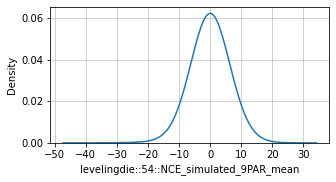

In [12]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.kdeplot(data = final_df.head(5000), x = var, ax = ax, bw_adjust = 10, label = None)
plt.grid(True, linestyle = '-', alpha = 0.7)

In [14]:
lower_threshold = np.percentile(final_df[var].dropna(),0.15)
upper_threshold = np.percentile(final_df[var].dropna(),99.85)
print(lower_threshold, upper_threshold)

-14.48252781032649 10.925744541978833


In [9]:
vardict = {
#    'levelingdie::29::NCE_simulated_9PAR_mean':'29_mean',
#    'levelingdie::29::NCE_simulated_9PAR_stddev':'29_stddev',
    'levelingdie::54::NCE_simulated_9PAR_mean':'54_mean', # done
#    'levelingdie::54::NCE_simulated_9PAR_stddev':'54_stddev',
#    'levelingdie::49::NCE_simulated_9PAR_mean':'49_mean', # done
#    'levelingdie::49::NCE_simulated_9PAR_stddev':'49_stddev',
#     'YL_49-21':'issue_dieloss',
}

In [10]:
#leveling_merge_final.to_csv(f'{pathsegment}/data.csv', index = False, header = leveling_merge_final.columns.tolist())

In [22]:
lotwaferlist = final_df['lot-wafer'].unique().tolist()

In [23]:
outputpath = '/cpiestage/jtlau/DS_project/testwafer_2'

In [24]:
final_df["lot-wafer"].nunique()

11037

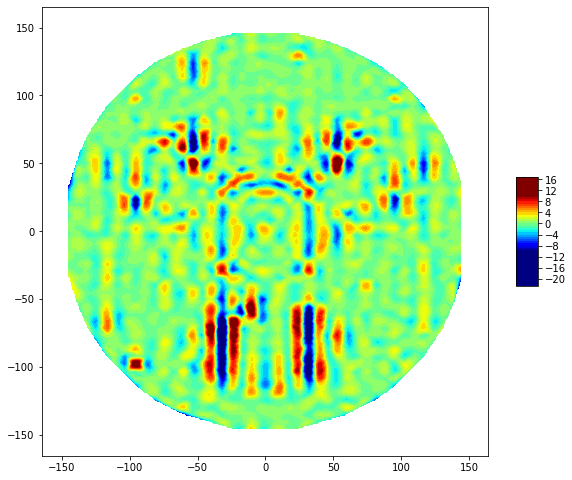

In [27]:
#plot and save image to folder
matplotlib.use('Agg')
for var, varname in vardict.items():
    for lotwafer in final_df['lot-wafer'].unique()[:1]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, aspect = 1)
        leveling_lotwafer = final_df.loc[final_df['lot-wafer'] == lotwafer]
        try:
            ll = -10
            ul = 10
            plot2d_inline(leveling_lotwafer,var, ax, ul, ll,contour = False, colorbar = True)
            fig.savefig(f'{outputpath}/{varname}_{lotwafer}')
            plt.close()
            plt.cla()
            plt.clf()
        except:
            pass

In [49]:
titlelist = [
    "29_mean",
    "54_mean",
    "49_mean",
    "29_stddev",
    "54_stddev",
    "49_stddev",
    'YL_49-21'
]

683886K-24


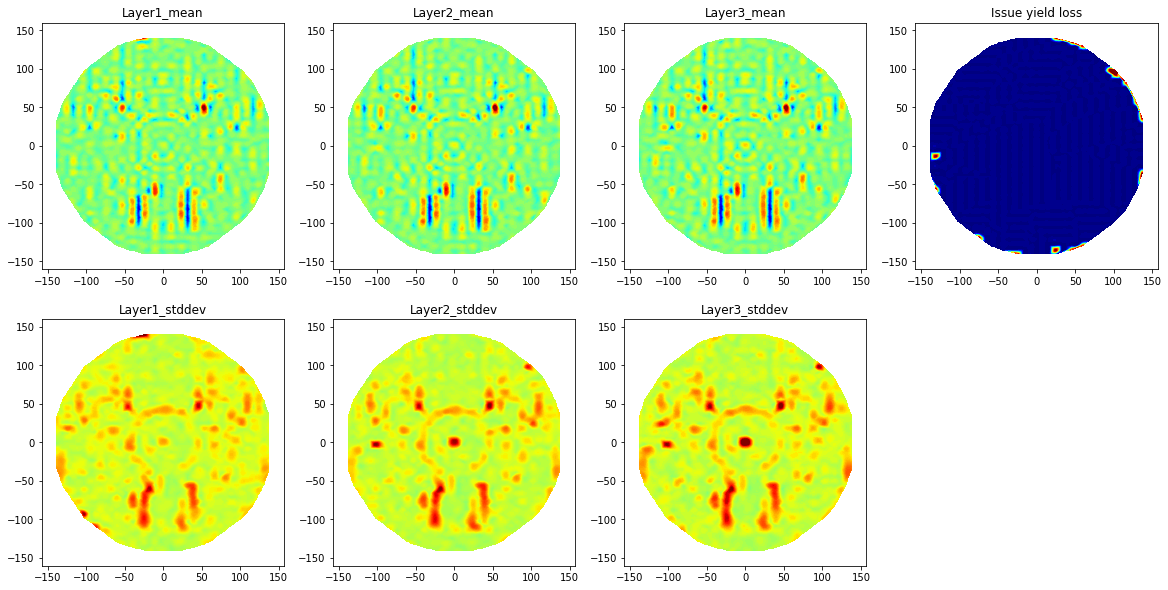

684713K-18


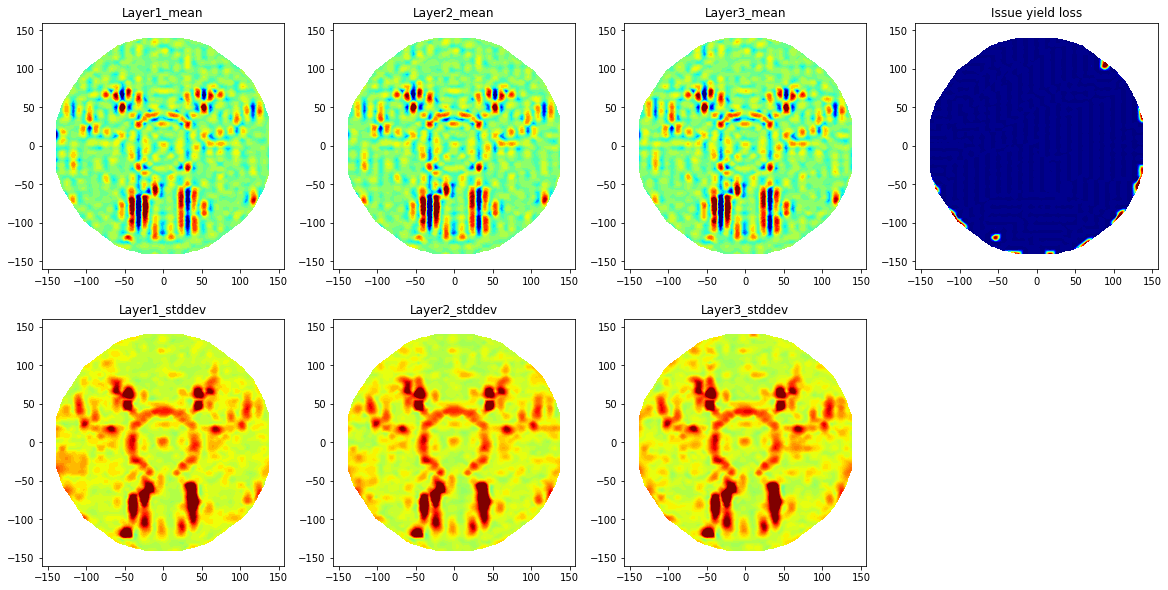

680998K-11


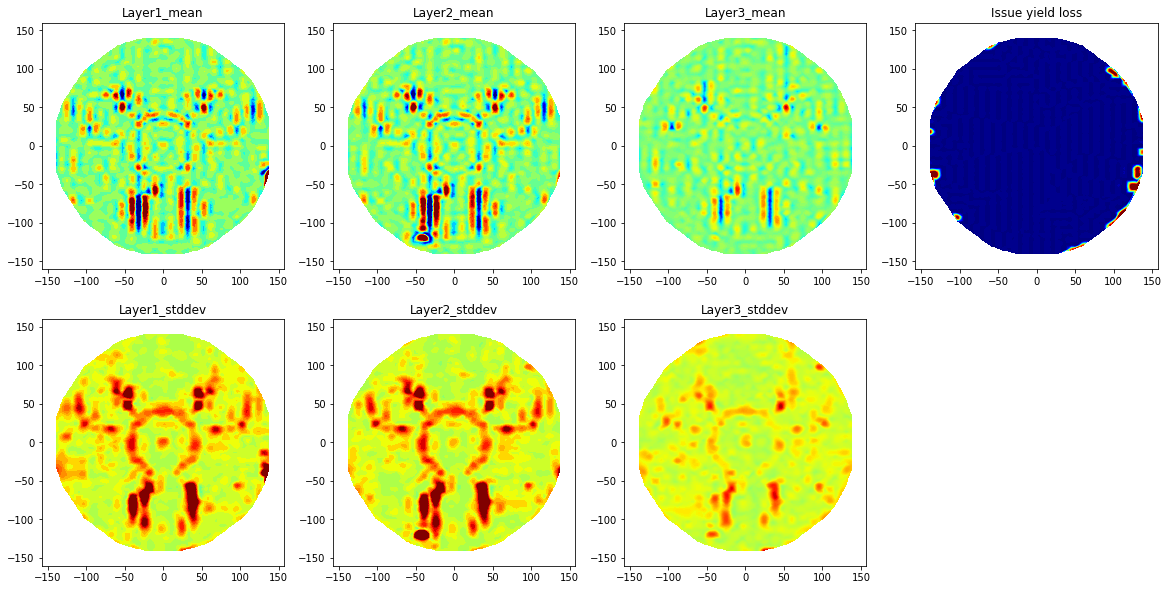

684593K-12


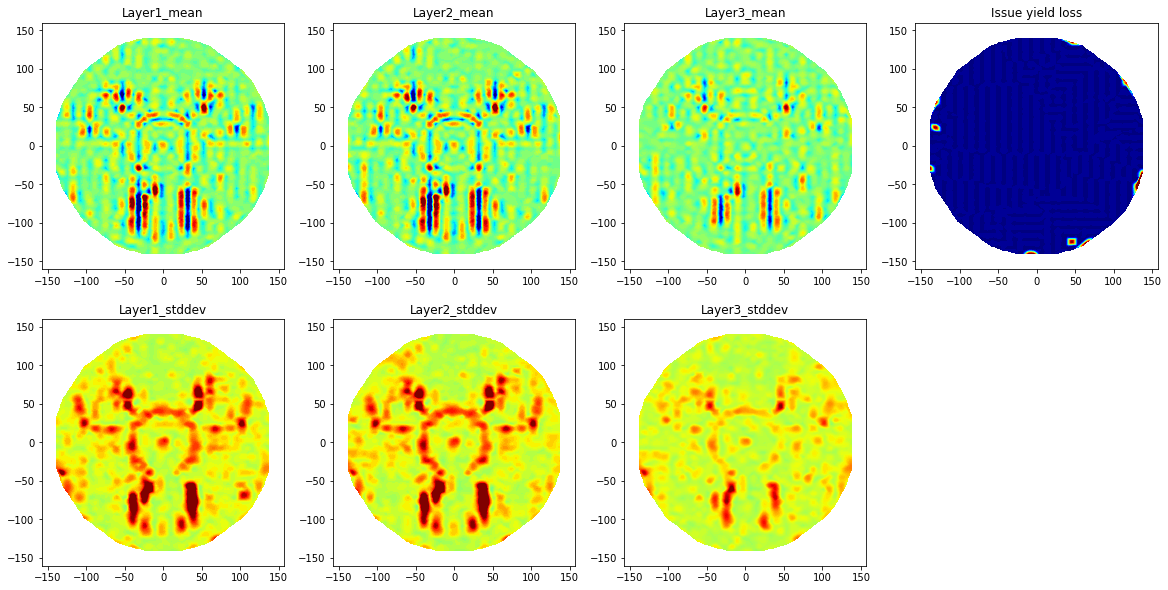

684894K-07


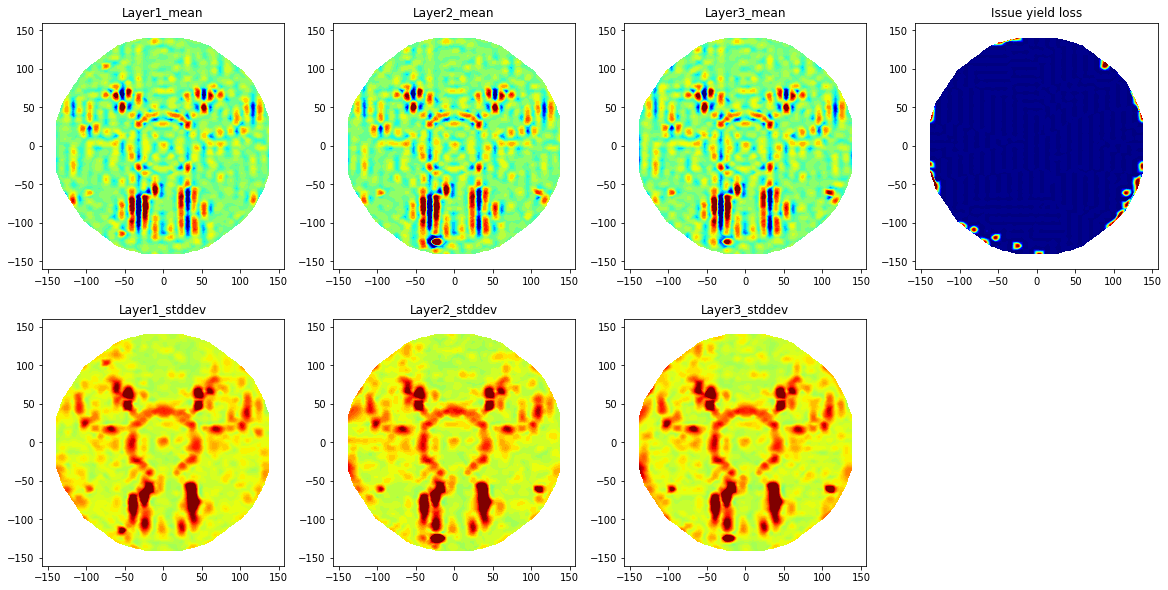

685931K-11


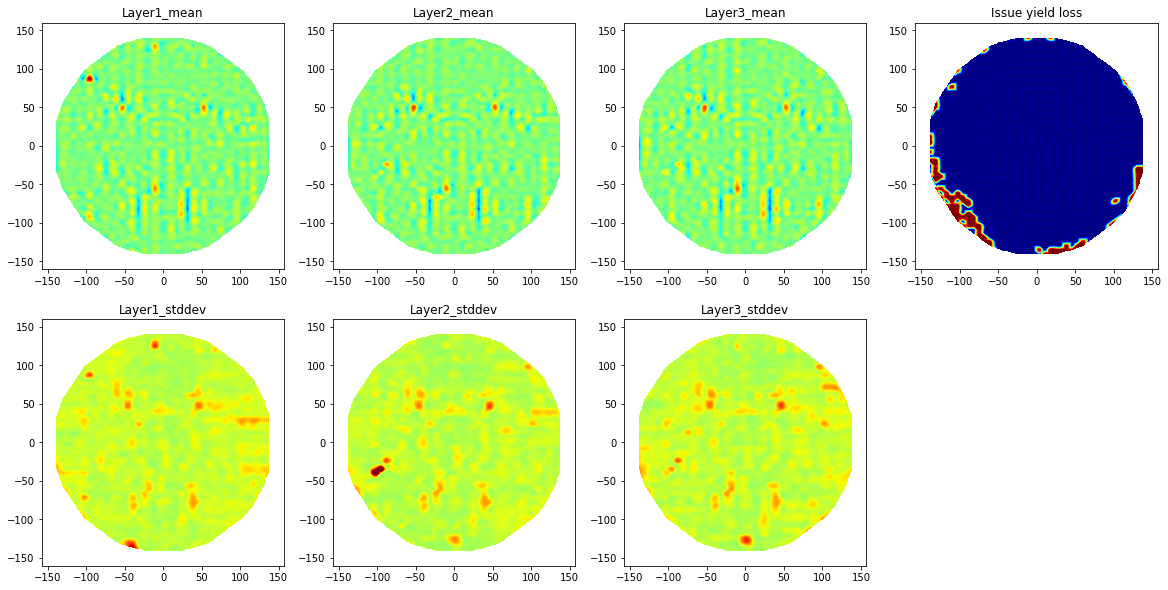

685843K-10


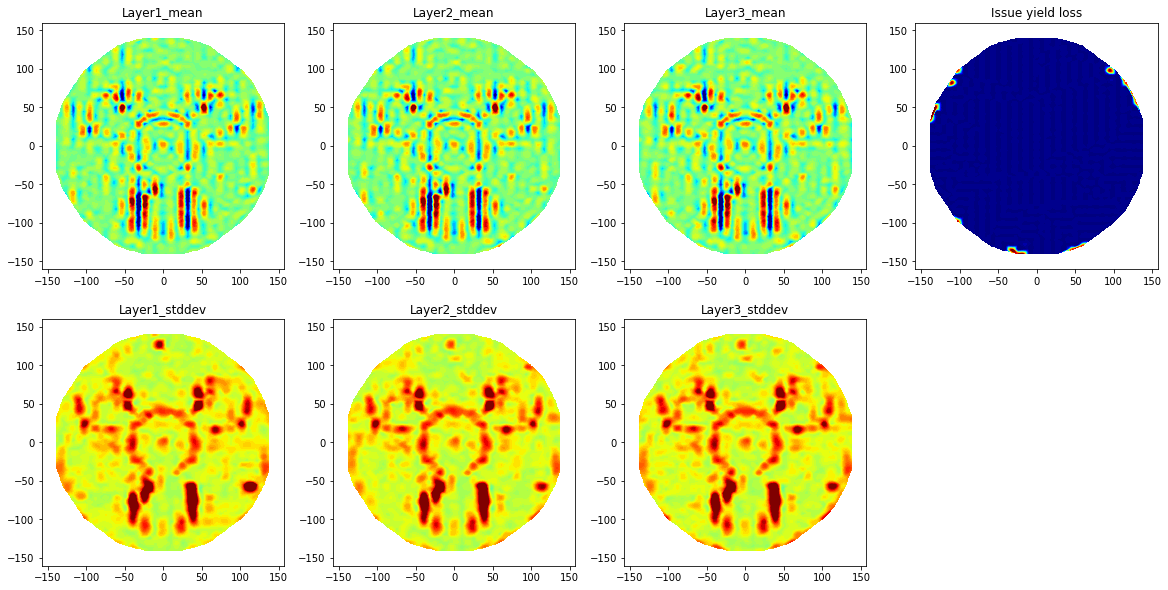

685846K-20


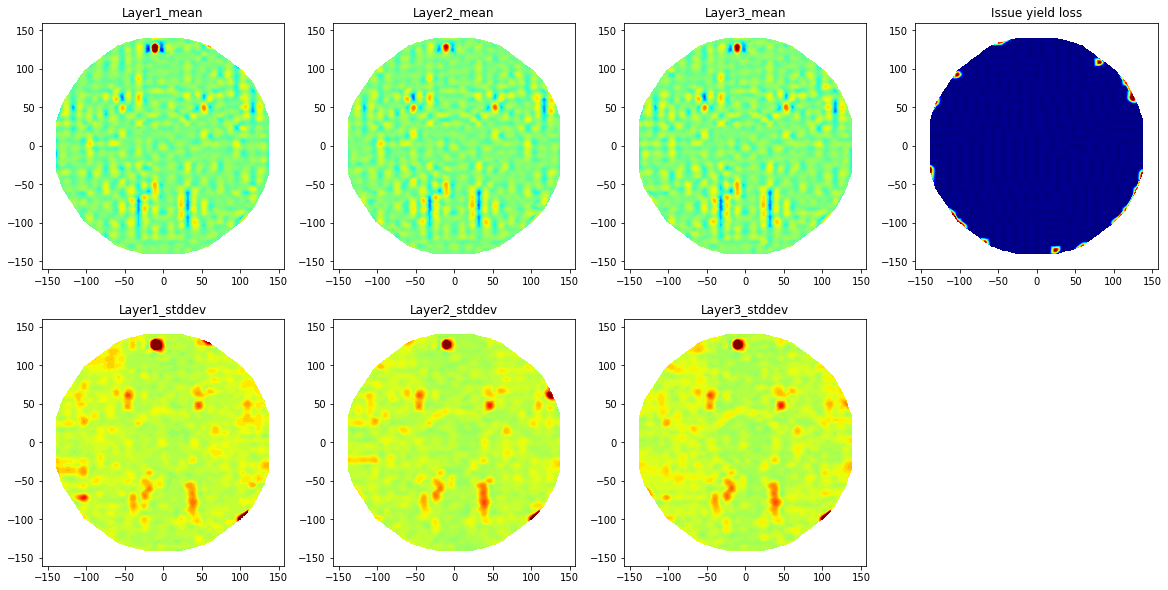

684422K-17


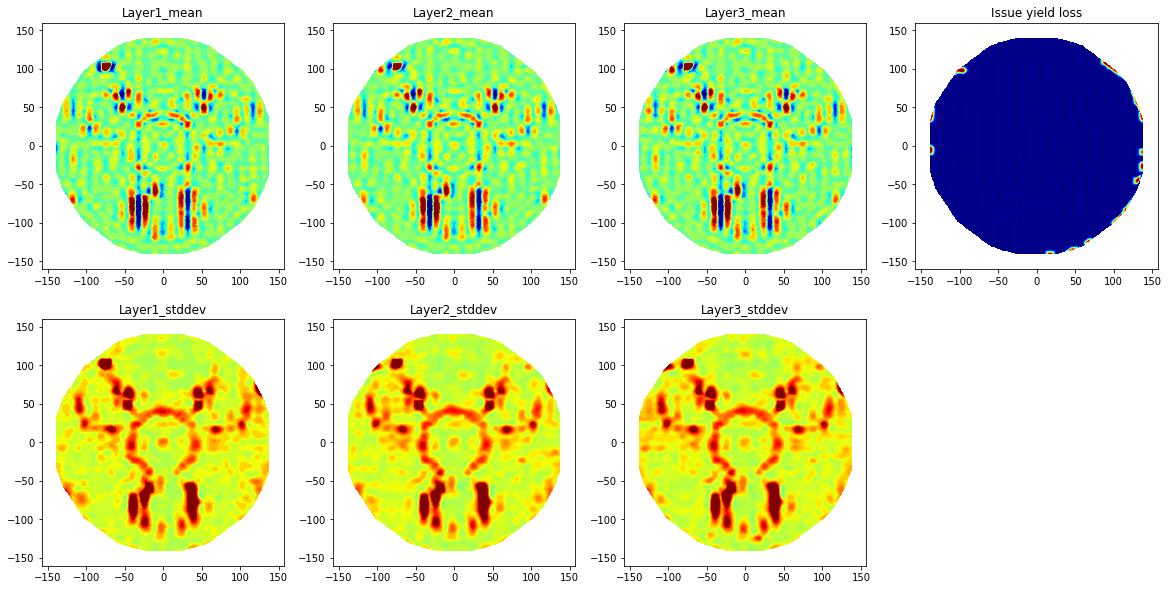

In [50]:
var1 = 'levelingdie::29::NCE_simulated_9PAR_mean'
var2 = 'levelingdie::29::NCE_simulated_9PAR_stddev'
var3 = 'levelingdie::54::NCE_simulated_9PAR_mean'
var4 = 'levelingdie::54::NCE_simulated_9PAR_stddev'
var5 = 'levelingdie::49::NCE_simulated_9PAR_mean'
var6 = 'levelingdie::49::NCE_simulated_9PAR_stddev'
var7 = 'YL_49-21'

ul = 10
ll = -10

for lotwafer in leveling_merge_final['lot-wafer'].unique()[:9]:
    print(lotwafer)
    fig = plt.figure(figsize=(20,10))
    leveling_lotwafer = leveling_merge_final.loc[leveling_merge_final['lot-wafer'] == lotwafer]
    
    #29 leveling mean=============================================================================
    ax1 = fig.add_subplot(241, aspect = 1)
    ax = ax1
    title = titlelist[0]
    var = var1
    
    plot2d_inline(leveling_lotwafer,var, ax, ul, ll, contour = False, colorbar = False)
    plottest(layout, ax, var, title)

    #54 leveling mean=============================================================================
    ax2 = fig.add_subplot(242, aspect = 1)
    ax = ax2
    title = titlelist[1]
    var = var3
    
    plot2d_inline(leveling_lotwafer,var, ax, ul, ll, contour = False, colorbar = False)
    plottest(layout, ax, var, title)
    
    #49 leveling mean =================================================================================
    ax3 = fig.add_subplot(243, aspect = 1)
    ax = ax3
    title = titlelist[2]
    var = var5
    
    plot2d_inline(leveling_lotwafer,var, ax, ul, ll, contour = False, colorbar = False)
    plottest(layout, ax, var, title)
    
    #29 leveling stddev=================================================================================
    ax4 = fig.add_subplot(245, aspect = 1)
    ax = ax4
    title = titlelist[3]
    var = var2
    
    plot2d_inline(leveling_lotwafer,var, ax, ul, ll, contour = False, colorbar = False)
    plottest(layout, ax, var, title)
    
    #54 leveling stddev =================================================================================
    ax5 = fig.add_subplot(246, aspect = 1)
    ax = ax5
    title = titlelist[4]
    var = var4
    
    plot2d_inline(leveling_lotwafer,var, ax, ul, ll, contour = False, colorbar = False)
    plottest(layout, ax, var, title)
    
    #49 leveling stddev =================================================================================
    ax6 = fig.add_subplot(247, aspect = 1)
    ax = ax6
    title = titlelist[5]
    var = var6
    
    plot2d_inline(leveling_lotwafer,var, ax, ul, ll, contour = False, colorbar = False)
    plottest(layout, ax, var, title)

    
    #4C leveling stddev =================================================================================
    ax7 = fig.add_subplot(244, aspect = 1)
    ax = ax7
    title = titlelist[6]
    var = var7
    
    plot2d_probe(leveling_lotwafer,var, ax, contour = False, colorbar = False)
    plottest(layout, ax, var, title)
    
    plt.show()
    
#     fig.savefig(f'{outputpath2}/54_mean_{lotwafer}.png')

In [10]:
import pandas as pd
import numpy as np
# import cds_funcs as cf
import glob
import os
import shutil
import cv2
import ipywidgets as widgets
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dot, Conv2D, MaxPool2D, Flatten
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import product
from sklearn import preprocessing
from sklearn import metrics
%matplotlib inline

# Check GPU setup in Colab
import tensorflow as tf

# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

# Check GPU coinfiguration in Colab (T4 GPU)
print("Tensorflow version: ", tf.__version__)
# Your expected output will be '/device:GPU:0'

Tensorflow version:  2.9.1


In [11]:
user_input = input("Enter Model:").lower()
model_dict = {
  "xception": ["Xception", "299", "xception"],
  "vgg16": ["VGG16", "224", "vgg16"],
  "vgg19": ["VGG19", "224", "vgg19"],
  "resnet50": ["ResNet50", "224", "resnet"],
  "resnet101": ["ResNet101", "224", "resnet"],
  "resnet152": ["ResNet152", "224", "resnet"],
  "inceptionv3":  ["InceptionV3", "299", "inception_v3"],
  "mobilenet":  ["MobileNet", "224", "mobilenet"],
  "mobilenetv2":  ["MobileNetV2", "224", "mobilenet"],
  "densenet121":  ["DenseNet121", "224", "densenet"],
  "densenet169":  ["DenseNet169", "224", "densenet"],
  "densenet201":  ["DenseNet201", "224", "densenet"],
  "nasnetmobile":  ["NASNetMobile", "224", "densenet"],
  "nasnetlarge":  ["NASNetLarge", "224", "densenet"],
  "efficientnetb0":  ["EfficientNetB0", "224", "efficientnet"],
  "efficientnetb1":  ["EfficientNetB1", "240", "efficientnet"],
  "efficientnetb2":  ["EfficientNetB2", "260", "efficientnet"],
  "efficientnetb3":  ["EfficientNetB3", "300", "efficientnet"],
  "efficientnetb4":  ["EfficientNetB4", "380", "efficientnet"],
  "efficientnetb5":  ["EfficientNetB5", "456", "efficientnet"],
  "efficientnetb6":  ["EfficientNetB6", "528", "efficientnet"],
  "efficientnetb7":  ["EfficientNetB7", "600", "efficientnet"]
}

temp = model_dict[user_input]
keras_model = temp[0]
model_input_shape = temp[1]
model_application =temp[2]
print(temp)

try:
    exec(f"from tensorflow.keras.applications import {keras_model}")
    exec(f"from tensorflow.keras.applications.{model_application} import preprocess_input,decode_predictions")
except Exception as e:
    print(e)

usermodel = eval(f"{keras_model}(weights='imagenet', include_top=False)") #, pooling='avg'
usermodel.summary()


Enter Model:vgg19
['VGG19', '224', 'vgg19']
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (Max

In [16]:
file_path_list = glob.glob('/cpiestage/jtlau/DS_project/nondrift/54_mean_*.png')

In [17]:
df = pd.DataFrame (file_path_list, columns = ['path'])
df['lot-wafer']=df['path'].str.split('/').str[-1].str.strip('.png').str.split("_").str[-1]
df

,path,lot-wafer
0,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691375K-24
1,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,689871K-11
2,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691375K-09
3,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691375K-13
4,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691375K-08
...,...,...
11032,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691712K-10
11033,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691712K-22
11034,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691712K-18
11035,/cpiestage/jtlau/DS_project/nondrift/54_mean_6...,691712K-06


In [ ]:
inline_img_link=[]
inline_feature=[]

for i in range(df.shape[0]):
    image = cv2.imread(df.path.iloc[i]) ### Load image
    dstImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ### OpenCV loads images in BGR
    dstImage=cv2.resize(dstImage, (224, 224)) ### Resize for CNN model
    inline_coeff = usermodel.predict(np.expand_dims(dstImage, 0),verbose=0)
    inline_coeff = np.sum(inline_coeff, axis=(1,2))
    inline_coeff = inline_coeff/np.linalg.norm(inline_coeff) # normalise features
    inline_feature.append(inline_coeff.reshape(-1))
    inline_img_link.append(df.path.iloc[i])

In [ ]:
extract_inline_df = pd.DataFrame(inline_img_link, columns =['path'])
extract_inline_df['lot-wafer']=extract_inline_df.path.str.split('/').str[-1].str.strip('.png').str.split("_").str[-1]
extract_inline_df=pd.concat([extract_inline_df,pd.DataFrame(np.stack(inline_feature, axis=0))],axis=1)
extract_inline_df

In [ ]:
#pd.DataFrame(extract_inline_df.std(), columns = ["stddev"]).plot()

In [ ]:
#extract_inline_df.to_csv(f'{pathsegment}/result/extracted_features_waferlevel_10.csv', index = False, header = extract_inline_df.columns.tolist())

In [37]:
equip_df = pd.read_csv('//cpiestage/jtlau/DS_project/equipment_data.csv', low_memory=False)
equip_df=equip_df.loc[:, ~equip_df.columns.str.startswith('BDIS')]
equip_df["lot-wafer"] = equip_df["StartLotKey"].map(lambda x: str(x)[:7]) + equip_df["WaferId"].map(lambda x: str(x)[4:])
equip_df = equip_df.astype(str)

In [38]:
extract_inline_df_merged = pd.merge(extract_inline_df, equip_df[["3010-4D PILLAR PHOTO::RunData::EquipmentId","lot-wafer"]],  on=["lot-wafer"]) #how='left',

In [39]:
extract_inline_df_merged['3010-4D PILLAR PHOTO::RunData::EquipmentId'].unique()

array(['PHVTK3D200', 'PHVTK1X900', 'PHVTK55500', 'nan'], dtype=object)

In [41]:
extract_inline_df_merged.groupby(['3010-4D PILLAR PHOTO::RunData::EquipmentId'])['lot-wafer'].count()

3010-4D PILLAR PHOTO::RunData::EquipmentId
PHVTK1X900    297
PHVTK3D200    193
PHVTK55500    498
nan             9
Name: lot-wafer, dtype: int64

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as hier
from sklearn import preprocessing, covariance, metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import calinski_harabasz_score

In [64]:
extract_inline_df = extract_inline_df_merged.loc[extract_inline_df_merged['3010-4D PILLAR PHOTO::RunData::EquipmentId'] == 'PHVTK55500']
extracted_values = extract_inline_df.iloc[:,-513:-1]

In [44]:
#extracted_values = extract_inline_df.iloc[:,-512:]

In [45]:
z = linkage(pdist(extracted_values, metric='cosine'), method='ward')
knee = np.diff(z[::-1, 2], 2)              # 2nd derivative of the distances
num_cluster = knee.argmax() + 2            # if idx 0 is the max of this we want 2 clusters
extract_inline_df['BCluster'] = hier.fcluster(z, num_cluster, criterion='maxclust')

#cluster=[2,3,4,5,6,7,8,9,10]
cluster=np.arange(2,40)
env = pd.DataFrame(np.zeros((38,2)), index=cluster,columns=['Silhouette','Calinski_Harabasz'])
for i in cluster:
    name='BCluster_' + str(i)
    cluster_label = hier.fcluster(z, i, criterion='maxclust')
    extract_inline_df[name]=cluster_label
    sc = metrics.silhouette_score(extracted_values, cluster_label, metric='matching')
    ch= metrics.calinski_harabasz_score(extracted_values, cluster_label)
    env.loc[i]=[sc,ch]
    
print ("Optimal No. of cluster: ", num_cluster)
env

<ipython-input-45-f353bf32f160>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_inline_df['BCluster'] = hier.fcluster(z, num_cluster, criterion='maxclust')
<ipython-input-45-f353bf32f160>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_inline_df[name]=cluster_label
/anaconda_env/personal/jtlau/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric matching
  warnings.warn(msg, DataConversionWarning)
<ipython-input-45-f

<ipython-input-45-f353bf32f160>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_inline_df[name]=cluster_label
/anaconda_env/personal/jtlau/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric matching
  warnings.warn(msg, DataConversionWarning)
<ipython-input-45-f353bf32f160>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_inline_df[name]=cluster_label
/anaconda_env/personal/jtlau/lib/python3.8/site-packages/sklearn

Optimal No. of cluster:  3


<ipython-input-45-f353bf32f160>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_inline_df[name]=cluster_label
/anaconda_env/personal/jtlau/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric matching
  warnings.warn(msg, DataConversionWarning)
<ipython-input-45-f353bf32f160>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_inline_df[name]=cluster_label
/anaconda_env/personal/jtlau/lib/python3.8/site-packages/sklearn

,Silhouette,Calinski_Harabasz
2,0.179829,76.421559
3,0.151442,58.680968
4,0.034696,53.612893
5,0.033717,45.512532
6,0.026810,43.616000
7,0.027000,38.307808
8,0.030891,35.433443
9,0.029275,32.660536
10,0.030577,30.636510
11,0.026398,29.757064


In [29]:
silhouette = [0.363,0.353,0.257,0.242,0.159,0.110]
calinski = [933, 941, 705, 561, 489, 430]
cluster = [2,3,4,5,6,7]

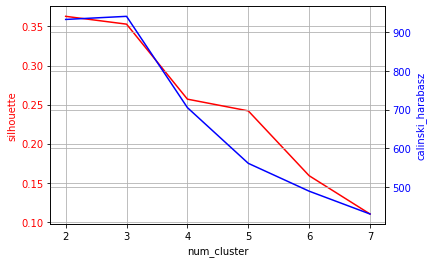

In [43]:
fig, ax1 = plt.subplots()
ax1.plot(cluster, silhouette, color="red", label="silhouette")
ax1.set_xlabel("num_cluster") 
ax1.set_ylabel("silhouette", color="red") 
ax1.tick_params(axis="y", labelcolor="red")
plt.grid(True)
ax2 = ax1.twinx()
ax2.plot(cluster, calinski, color="blue", label="calinski_harabasz")
ax2.set_ylabel("calinski_harabasz", color="blue") 
ax2.tick_params(axis="y", labelcolor="blue")
plt.grid(True)
plt.show()

In [ ]:
num_cluster

In [ ]:
def get_cluster(n, extract_inline_df):
    fig = plt.figure(figsize=(20, 9))
    columns = 10
    rows = len(extract_inline_df[f'BCluster_{n}'].unique())

    h=0
    for j in range(1, columns*rows +1):
        if j % columns ==0:
            h=0
        cluster_no=math.floor((j-1)//columns)+1
        temp_cluster_df = extract_inline_df[extract_inline_df[f'BCluster_{n}']==n]
        img = cv2.imread(temp_cluster_df.path.iloc[h])
        h=h+1
        fig.add_subplot(rows, columns, j)
        plt.box(False)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
        if j % columns ==0:
            l=j-columns
            fig.axes[l].set_ylabel('Cluster_'+str(cluster_no), weight = 'bold', fontsize = 12)
        else:
            pass

    plt.show()

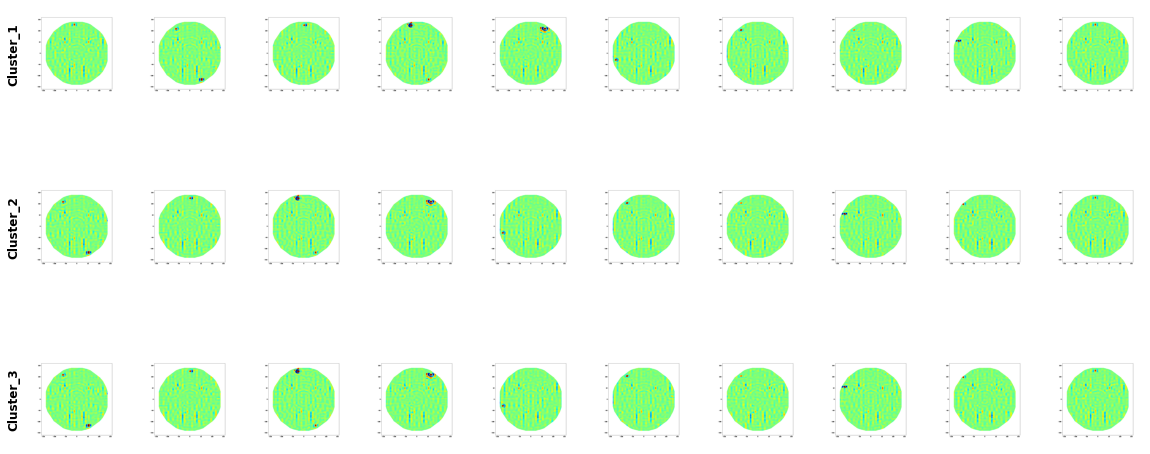

In [48]:
get_cluster(3,extract_inline_df)

In [ ]:
full_info_df = pd.merge(extract_inline_df, equip_df,  on=["lot-wafer"]) #how='left',
full_info_df.columns = full_info_df.columns.astype(str)
chamber_df = pd.concat([full_info_df.loc[:, full_info_df.columns.str.contains('CHAMBER')],full_info_df.loc[:, full_info_df.columns.str.contains('Equipment')]],axis=1)
chamber_df = chamber_df.astype(str)

In [52]:
full_info_df.to_csv(f'{pathsegment}/result/clustering_waferlevel_10.csv', index = False, header = full_info_df.columns.tolist())

In [164]:
from collections import Counter

def match_pct(chamber, full_info_df, n):
    diff_dict = {}
    chamber_check = full_info_filt.loc[full_info_filt[chamber_df.columns.values[i]] == chamber][f'BCluster_{n}']
    check_df = pd.DataFrame(chamber_check.groupby(chamber_check).count())
    n_clusters = check_df.max().values[0]
    n_chambers = check_df.sum().values[0]
    cluster_num = check_df.idxmax()[0]
    PCT_match = n_clusters/n_chambers
    cluster_counts = full_info_filt.loc[full_info_filt[f'BCluster_{n}'] == cluster_num]['lot-wafer'].count()
    fp = cluster_counts - n_clusters
    PCT_match = n_clusters/(fp + n_chambers)
    return PCT_match*100

def match_cluster(chamber, full_info_df, n):
    diff_dict = {}
    chamber_check = full_info_filt.loc[full_info_filt[chamber_df.columns.values[i]] == chamber][f'BCluster_{n}']
    check_df = pd.DataFrame(chamber_check.groupby(chamber_check).count())
    cluster = check_df.idxmax()[0]
    return cluster

def get_counts_cluster(chamber, full_info_df, n):
    diff_dict = {}
    chamber_check = full_info_filt.loc[full_info_filt[chamber_df.columns.values[i]] == chamber][f'BCluster_{n}']
    check_df = pd.DataFrame(chamber_check.groupby(chamber_check).count())
    n_clusters = check_df.max().values[0]
    n_chambers = check_df.sum().values[0]
    PCT_match = n_clusters/n_chambers
    return n_clusters

def get_counts_cluster_total(chamber, full_info_df, n):
    diff_dict = {}
    chamber_check = full_info_filt.loc[full_info_filt[chamber_df.columns.values[i]] == chamber][f'BCluster_{n}']
    check_df = pd.DataFrame(chamber_check.groupby(chamber_check).count())
    n_clusters = check_df.max().values[0]
    n_chambers = check_df.sum().values[0]
    cluster_num = check_df.idxmax()[0]
    cluster_counts = full_info_filt.loc[full_info_filt[f'BCluster_{n}'] == cluster_num]['lot-wafer'].count()
    return cluster_counts

In [170]:
le = preprocessing.LabelEncoder()
traveller_step=[]
rand_score = []
adjusted_rand=[]
n_clusters=[]
chambers = []
matching_cluster = []
PCT_match = []
matching_chamber = []
chamber_count = []
cluster_count = []
cluster_count_total = []

for i in range(chamber_df.shape[1]):
    
    checklist = pd.DataFrame(chamber_df.loc[chamber_df[chamber_df.columns.values[i]] != "nan"][chamber_df.columns.values[i]].copy())
    checklist[chamber_df.columns.values[i]] = checklist[chamber_df.columns.values[i]].astype(str)
    full_info_filt = full_info_df.loc[full_info_df[chamber_df.columns.values[i]] != "nan"].copy()
    
    n = checklist[chamber_df.columns.values[i]].nunique()
    
    
    if n > 1:
        le.fit(checklist[chamber_df.columns.values[i]])
        le.transform(checklist[chamber_df.columns.values[i]])
        traveller_step.append(chamber_df.columns.values[i])
        rand_score.append(metrics.rand_score(le.transform(checklist[chamber_df.columns.values[i]]), full_info_filt[f'BCluster_{n}'].values))
        adjusted_rand.append(metrics.adjusted_rand_score(le.transform(checklist[chamber_df.columns.values[i]]), full_info_filt[f'BCluster_{n}'].values))
        n_clusters.append(n)
        chambers.append(checklist[chamber_df.columns.values[i]].unique())
        
        #cluster_quantity = Counter(full_info_filt[f'BCluster_{n}'].values)
        custom_metric = pd.DataFrame(checklist[chamber_df.columns.values[i]].groupby(checklist[chamber_df.columns.values[i]]).count())
        custom_metric = custom_metric.reset_index(names = ["chamber"])
        custom_metric["PCT_match"] = custom_metric["chamber"].apply(lambda x : match_pct(x, full_info_df, n))
        custom_metric["cluster"] = custom_metric["chamber"].apply(lambda x : match_cluster(x, full_info_df, n))
        custom_metric["cluster_count"] = custom_metric["chamber"].apply(lambda x : get_counts_cluster(x, full_info_df, n))
        custom_metric["cluster_count_total"] = custom_metric["chamber"].apply(lambda x : get_counts_cluster_total(x, full_info_df, n))
        
        row_of_interest = custom_metric.loc[custom_metric["PCT_match"] == custom_metric["PCT_match"].max()]
        
        chamber_count.append(row_of_interest[chamber_df.columns.values[i]].values[0])
        cluster_count.append(row_of_interest["cluster_count"].values[0])
        cluster_count_total.append(row_of_interest["cluster_count_total"].values[0])
        matching_chamber.append(row_of_interest["chamber"].values[0])
        matching_cluster.append(row_of_interest["cluster"].values[0])
        PCT_match.append(row_of_interest["PCT_match"].values[0])
        
            
potential_match_df = pd.DataFrame({'traveller_step': traveller_step, 
                                   'matching cluster':matching_cluster,
                                   'matching chamber':matching_chamber,
                                   'rand_index':rand_score, 
                                   'adjusted_rand_index':adjusted_rand,
                                   'PCT_match':PCT_match,
                                   'n_wafers_chamber':chamber_count,
                                   'n_wafers_cluster_match':cluster_count,
                                   'n_wafers_cluster_total':cluster_count_total,
                                   'n_clusters':n_clusters, 
                                   #'chambers': chambers,
                                  })
potential_match_df=potential_match_df.sort_values(by=['PCT_match','n_wafers_chamber'],ascending=[False, False]).reset_index(drop=True)

traveller_step_picked=potential_match_df.traveller_step[0].split('::')[0]
potential_match_df.traveller_step[0].split('::')[0]

'5030-49 CONTACT OXIDE DRY ETCH'

In [171]:
pd.set_option('display.max_colwidth', None)

In [172]:
potential_match_df

,traveller_step,matching cluster,matching chamber,rand_index,adjusted_rand_index,PCT_match,n_wafers_chamber,n_wafers_cluster_match,n_wafers_cluster_total,n_clusters
0,5030-49 CONTACT OXIDE DRY ETCH::RunData::EquipmentId,1,TAVLK7KL00,0.499578,-0.000443,43.793911,244,187,370,2
1,5030-49 CONTACT INTEGRATED DRY ETCH 2::RunData::EquipmentId,1,TAVSK7CM00,0.469524,-0.003801,31.924883,191,136,371,3
2,5030-54 BL INTEGRATED DRY ETCH::WaferData::Product::Tool::PROCESS_CHAMBER - WAFER_ATTR,27,L2KGK39A40,0.880330,0.005808,28.571429,6,2,3,27
3,5030-49 CONTACT INTEGRATED DRY ETCH::RunData::EquipmentId,2,TAS2K7A200,0.573998,0.000854,27.027027,205,90,218,4
4,4110-54 SPACER OXIDE DEP 2::RunData::EquipmentId,2,TPAXK5F400,0.607702,0.011496,26.710098,171,82,218,5
5,5030-49 LINER INTEGRATED DRY ETCH::RunData::EquipmentId,2,ASC3K2C900,0.597408,0.003073,24.666667,156,74,218,5
6,5030-29 RAD INTEGRATED DRY ETCH::RunData::EquipmentId,2,L2KGK7AB00,0.590551,0.004213,24.414716,155,73,217,4
7,5030-54 BL INTEGRATED DRY ETCH::RunData::EquipmentId,2,L2KGK99900,0.597399,0.003457,22.807018,132,65,218,5
8,5030-40 CONTACT POLY DRY ETCH::RunData::EquipmentId,2,ASC3K1P700,0.604149,0.002385,20.363636,113,56,218,5
9,5030-21 STI INTEGRATED DRY ETCH::RunData::EquipmentId,2,ASC3K98L00,0.638030,0.008226,19.650655,122,45,152,6


### PCA

In [38]:
from sklearn.decomposition import PCA

In [39]:
extract_transposed = extract_inline_df.set_index('lot-wafer').transpose()[1:513]

In [40]:
extract_transposed

lot-wafer,683886K-24,684713K-18,680998K-11,684593K-12,684894K-07,685931K-11,685843K-10,685846K-20,684422K-17,685886K-03,...,687365K-05,689111K-24,686854K-13,689140K-22,686993K-02,688302K-03,687231K-07,688385K-22,692025K-14,683085K-23
0,0.008362,0.003493,0.004247,0.01553,0.003801,0.012005,0.010832,0.015419,0.004939,0.014881,...,0.006537,0.003928,0.018146,0.001326,0.011697,0.005244,0.001616,0.010427,0.016385,0.012133
1,0.0,0.002715,0.000998,0.011273,0.005167,0.0,0.028816,0.0,0.001199,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013489,0.00591
2,0.034612,0.055431,0.045009,0.057227,0.053225,0.018981,0.058144,0.027035,0.054098,0.025702,...,0.030232,0.017593,0.022025,0.026191,0.029745,0.02399,0.013831,0.023342,0.065134,0.05904
3,0.020315,0.005962,0.004012,0.009757,0.002195,0.013285,0.004905,0.013904,0.00775,0.021442,...,0.020868,0.032544,0.016181,0.01974,0.014661,0.011482,0.044281,0.048681,0.001529,0.0
4,0.085972,0.07648,0.077861,0.077885,0.07319,0.092176,0.077651,0.086419,0.07309,0.087082,...,0.089562,0.084913,0.092522,0.090555,0.087973,0.085995,0.074278,0.089028,0.076778,0.017423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.007153,0.006981,0.008489,0.009332,0.008008,0.004529,0.010142,0.008308,0.013166,0.004652,...,0.003914,0.007105,0.005231,0.005417,0.004927,0.005291,0.008845,0.006104,0.00829,0.009518
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001175
510,0.008082,0.006818,0.006458,0.009094,0.006765,0.00903,0.006212,0.006272,0.004002,0.007122,...,0.007516,0.0073,0.008701,0.008988,0.008857,0.008659,0.007124,0.009533,0.00716,0.001085


In [41]:
extract_transposed.to_csv(f'{pathsegment}/result/extract_transposed_1.csv', index = False, header = extract_transposed.columns.tolist())

In [42]:
extract_transposed = pd.read_csv(f'{pathsegment}/result/extract_transposed_1.csv')

In [43]:
extract_transposed = extract_transposed.astype("float")

In [44]:
extract_transposed.describe()

,683886K-24,684713K-18,680998K-11,684593K-12,684894K-07,685931K-11,685843K-10,685846K-20,684422K-17,685886K-03,...,687365K-05,689111K-24,686854K-13,689140K-22,686993K-02,688302K-03,687231K-07,688385K-22,692025K-14,683085K-23
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,0.018939,0.019798,0.019633,0.019850,0.019605,0.018760,0.020087,0.018903,0.019784,0.018957,...,0.018454,0.018701,0.018798,0.019081,0.018520,0.018525,0.019035,0.019448,0.019961,0.017325
std,0.039969,0.039550,0.039632,0.039524,0.039646,0.040054,0.039404,0.039987,0.039557,0.039961,...,0.040196,0.040082,0.040036,0.039902,0.040166,0.040163,0.039924,0.039724,0.039468,0.040697
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001266,0.002039,0.001618,0.001582,0.002341,0.000950,0.002077,0.001290,0.001782,0.001381,...,0.000861,0.000926,0.001238,0.001241,0.001205,0.001061,0.001473,0.001475,0.001283,0.001105
75%,0.021184,0.020463,0.020250,0.018713,0.022022,0.018518,0.020645,0.018651,0.020997,0.018739,...,0.018124,0.017645,0.017532,0.020059,0.017493,0.017661,0.020080,0.020857,0.019198,0.013318
max,0.313821,0.324629,0.322876,0.291686,0.360140,0.362478,0.306934,0.321898,0.318096,0.335363,...,0.354117,0.312369,0.311371,0.319193,0.342601,0.347271,0.314920,0.328404,0.295188,0.406773


In [45]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(extract_transposed)

In [46]:
pca = PCA(n_components = 5)
df_pca = pca.fit_transform(df_standardized)

In [47]:
df_pca_result = pd.DataFrame(data=df_pca, columns = ['PC1','PC2','PC3','PC4','PC5'])

In [63]:
df_pca_result

,PC1,PC2,PC3,PC4,PC5
0,-9.347762,0.510162,-1.304962,-1.240354,-0.136200
1,-12.971456,-2.563626,-1.536581,-0.118742,-0.248287
2,10.718207,-10.138379,-3.476722,-0.411668,0.988971
3,0.431889,5.912624,5.100572,1.232204,-1.540200
4,51.660796,3.340913,0.029839,-0.384829,0.412412
...,...,...,...,...,...
507,-9.193402,-0.762537,0.236554,0.714087,-0.432564
508,-15.253231,0.599137,0.160096,-0.156825,0.130930
509,-15.252427,0.597820,0.159369,-0.156432,0.131879
510,-9.247292,0.824787,0.061588,-0.518904,0.339890


In [64]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

listdict = []
for col in extract_transposed.columns:
    vector1 = extract_transposed[col].values
    wafer_dict = {}
    wafer_dict["lot-wafer"] = col
    
    for PC in df_pca_result.columns:
        vector2 = df_pca_result[PC].values
        
        vector1 = vector1.reshape(1,-1)
        vector2 = vector2.reshape(1,-1)
        similarity_matrix = cosine_similarity(vector1, vector2)
        cos_sim = similarity_matrix[0,0]

#         correlation_coefficient, p_value = pearsonr(vector1, vector2)
        
        wafer_dict[PC] = cos_sim
        
    listdict.append(wafer_dict)

In [65]:
PC_df = pd.DataFrame(listdict)

In [66]:
PC_df

,lot-wafer,PC1,PC2,PC3,PC4,PC5
0,683886K-24,0.890407,-0.019915,0.100837,-0.028040,0.046242
1,684713K-18,0.853602,-0.244223,-0.037153,0.017829,0.066305
2,680998K-11,0.858336,-0.233637,-0.016192,0.021460,0.046599
3,684593K-12,0.851807,-0.229520,-0.032816,-0.055534,-0.073031
4,684894K-07,0.851388,-0.237552,0.011439,0.030476,0.064788
...,...,...,...,...,...,...
996,688302K-03,0.891761,0.145912,-0.025281,-0.029105,-0.008900
997,687231K-07,0.878985,-0.062097,0.124776,-0.038301,0.026738
998,688385K-22,0.882740,0.112051,-0.019108,0.019121,0.029371
999,692025K-14,0.849810,-0.242868,-0.048032,-0.064221,-0.054684


In [67]:
PC_df.describe()

,PC1,PC2,PC3,PC4,PC5
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.872087,-0.000198,-0.000301,0.000170,-0.000056
std,0.015774,0.170773,0.077249,0.049480,0.036372
min,0.784875,-0.277711,-0.143203,-0.085867,-0.105627
25%,0.857631,-0.215793,-0.057549,-0.034492,-0.026060
50%,0.877794,0.026633,-0.024827,-0.009378,0.003142
75%,0.884760,0.159155,0.033176,0.024525,0.025842
max,0.895528,0.233468,0.220542,0.230350,0.113403
